In [1]:
# Import libraries for:

# Web scraping
import requests 
from bs4 import BeautifulSoup

# Data analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd

# Import self-defined functions
from myfuncs import *

# Set random seed
np.random.seed(42)

/Users/ningnong/Desktop/MADS/SIADS696_MilestoneII/Air Travel Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Unsupervised Learning
**Objectives:**
- Segment air travelers into distinct groups based on their states of origin, with the expectation that each group may exhibit unique air travel behaviors.
- Reduce the dimensionality of state-level data to eliminate feature correlations and redundancies.
- Perform clustering on the transformed features to identify meaningful traveler segments.

## Data Extraction & Preprocessing

In [2]:
# Extract data from US Census Bureau

# Define input variables for the extraction
apikey_USCB = 'b83c9e8cbf71b387db3681c39e0d7ef719f6344f'
variables_USCB = ['B19013_001E','B19301_001E','B23025_005E','B23025_003E','B19083_001E','B01003_001E','B01002_001E','B05002_013E','B25077_001E']

# Extract data from USCB API
acs_2023_df = extract_and_preprocess_ACS(api_key=apikey_USCB, year=2023, variables=variables_USCB, state_code=None)
acs_2022_df = extract_and_preprocess_ACS(api_key=apikey_USCB, year=2022, variables=variables_USCB, state_code=None)
# Combine 2023 and 2033 data 
acs_df = pd.concat([acs_2022_df, acs_2023_df],axis=0) 
acs_df = acs_df.sort_index(axis=1)
acs_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),Total Population,Unemployment Rate,Year
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,01,5074296.0,0.020345,2022
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,02,733583.0,0.022471,2022
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,04,7359197.0,0.020918,2022
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,05,3045637.0,0.020475,2022
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,06,39029342.0,0.027180,2022


In [3]:
# Extract state mapper with FIPS code and state names
state_df = extract_state_mapper()
state_df.head()

,State Name,State Code (FIPS),State Code (USPS)
0,Alabama,01,AL
1,Alaska,02,AK
2,Arizona,04,AZ
3,Arkansas,05,AR
4,California,06,CA


In [4]:
# Add state name to acs data based on FIPS code
acs_2023_df = pd.merge(acs_2023_df, state_df, on = 'State Code (FIPS)', how = 'left')
acs_2022_df = pd.merge(acs_2022_df, state_df, on = 'State Code (FIPS)', how = 'left')
acs_df = pd.merge(acs_df, state_df, on = 'State Code (FIPS)', how = 'left')

# Save to csv
acs_df.to_csv('assets/acs_2023_df.csv',index=None)
acs_df.to_csv('assets/acs_2022_df.csv',index=None)
acs_df.to_csv('assets/acs_df.csv',index=None)
acs_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),Total Population,Unemployment Rate,Year,State Name,State Code (USPS)
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,01,5074296.0,0.020345,2022,Alabama,AL
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,02,733583.0,0.022471,2022,Alaska,AK
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,04,7359197.0,0.020918,2022,Arizona,AZ
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,05,3045637.0,0.020475,2022,Arkansas,AR
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,06,39029342.0,0.027180,2022,California,CA


## EDA

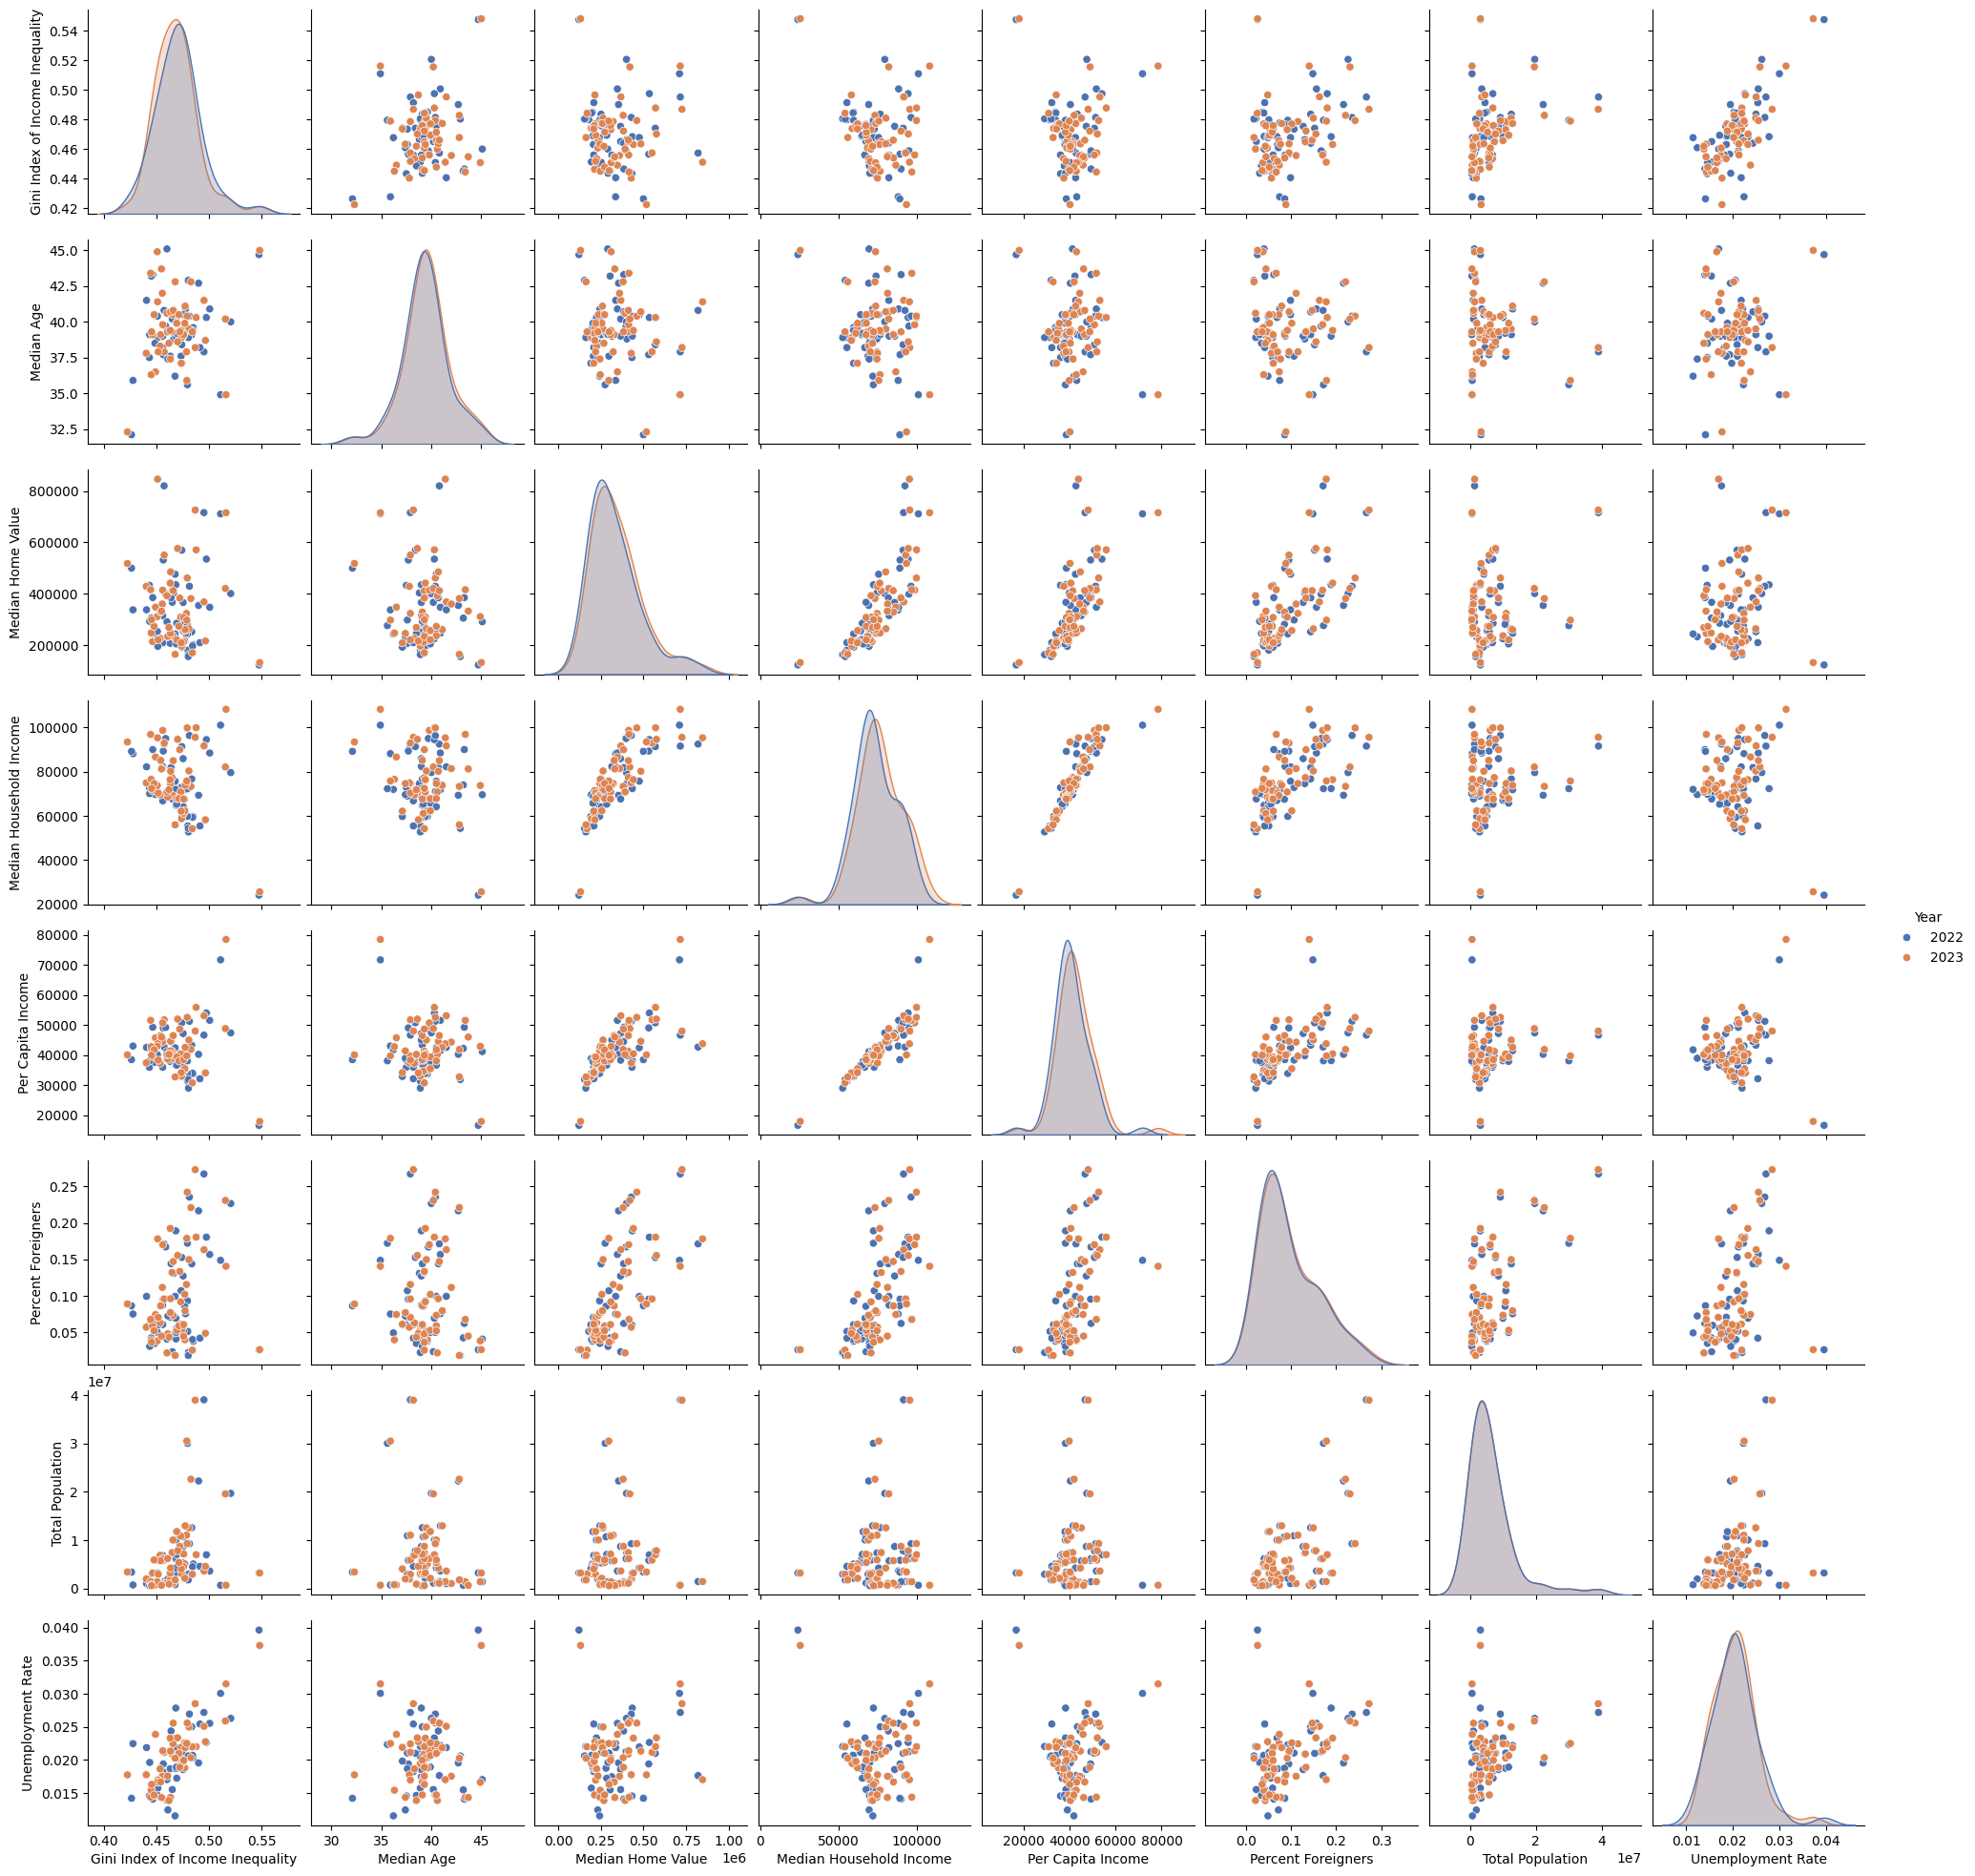

In [5]:
# Plot SPLOM to see any dependencies/ correlations among the features
numeric_and_year_cols = [col for col in acs_df.columns if 'State' not in col]

# SPLOM by year
img_name = 'acs_SPLOMs_byYear'
tmp = acs_df[numeric_and_year_cols].copy()
sns.pairplot(tmp, hue="Year", palette='deep')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Findings**
- Dominance of Linear correlations --> PCA linearity assumption largely holds. 
- No clear differences between 2022 and 2023 data. --> Use 2023 data for analysis

## Dimensionality Reduction

### PCA

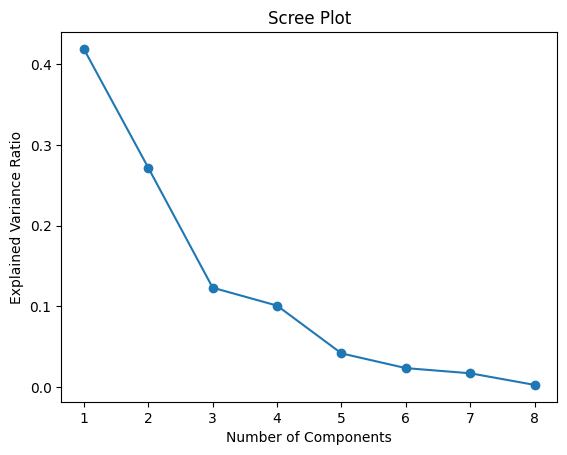

In [6]:
# Normalize for PCA
scaler = StandardScaler()
acs_2023_df_scaled = acs_2023_df.copy()

# Select numeric cols
numeric_cols = [col for col in numeric_and_year_cols if col != "Year"]
acs_2023_df_scaled[numeric_cols] = scaler.fit_transform(acs_2023_df_scaled[numeric_cols])

# Perform PCA 
pca = PCA() # Default n_components = number of existing features
pca.fit(acs_2023_df_scaled[numeric_cols])


# Select n_components:

# Option 1 (not chosen): Based on Explained Variance -> 6
explainedVariance = pca.explained_variance_ratio_
explainedVariance_cum = np.cumsum(pca.explained_variance_ratio_)
explainedVariance_cum
# n_components = np.argmax(explainedVariance_cum >= 0.95) + 1 #np.argmax returns the index of the first occurence of max value ('1') - i.e. index of first element which satisfy the criteria >0.95
# n_components #np.int64(6)

# Option 2 (chosen): Based on Visual inspection of Scree plot using Elbow method -> 3
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show() # choose n=3

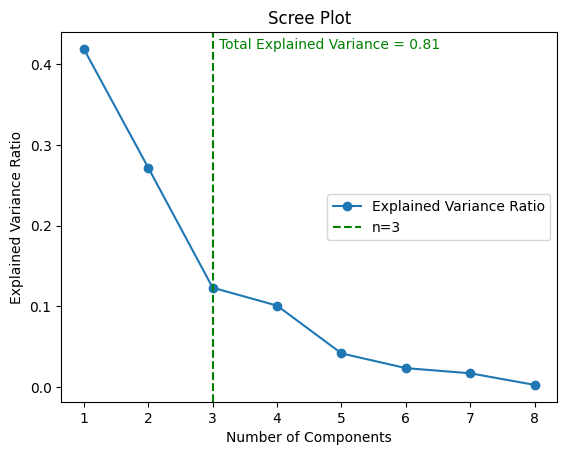

In [7]:
# Final Scree Plot

# Option 2 (chosen): Based on visual inspection -> 3 components
n_components = 3
explained_variance_at_3 = explainedVariance_cum[n_components - 1]  # Cumulative explained variance at PC = 3

# Plot Scree Plot with vertical line at n = 3
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o', label='Explained Variance Ratio')

# Add vertical line at PC = 3
plt.axvline(x=n_components, color='g', linestyle='--', label=f'n={n_components}')

# Annotate with explained variance at PC = 3
plt.text(n_components + 0.1, explainedVariance[0], f'Total Explained Variance = {explained_variance_at_3:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Save and show plot
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

In [8]:
# Perform final PCA with 3 components
n=3
pca = PCA(n_components=n)
pca_2023_result = pca.fit_transform(acs_2023_df_scaled[numeric_cols])

# PCA results 
pca_2023_df = pd.DataFrame(pca_2023_result, columns=[f'PC{i+1}' for i in range(n)])
# Concatenate the original data with PCA components
acs_with_pca_2023_df = pd.concat([acs_2023_df.reset_index(drop=True), pca_2023_df], axis=1)
# acs_with_pca_2023_df.to_csv('assets/acs_with_pca_2023.csv') 
acs_with_pca_2023_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Name,State Code (USPS),PC1,PC2,PC3
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,Alabama,AL,-1.817882,0.407587,-0.245614
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,Alaska,AK,0.375078,-1.054928,-0.636094
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,Arizona,AZ,0.464010,-0.009276,-0.163031
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,Arkansas,AR,-2.022604,0.424492,-0.493996
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,California,CA,5.039345,2.426022,-1.864246


In [9]:
# Look into how the original features contribute to each PC's

# Component contributions (loadings)
component_cont = pca.components_
# component_cont
pca_components_df = pd.DataFrame(component_cont, columns=numeric_cols, index=[f'PC{i+1}' for i in range(n)])
pca_components_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,Total Population,Unemployment Rate
PC1,0.085369,-0.129019,0.469444,0.473149,0.453934,0.473651,0.247584,0.200299
PC2,0.610310,0.196021,-0.138316,-0.309755,-0.195426,0.175410,0.326866,0.546093
PC3,0.145436,0.812192,0.152164,0.105712,0.235513,-0.051194,-0.475288,0.029638


**Main PC Components** 
- PC1: Home Value, Income (Household & Per Capita), Percent Foreigners 
- PC2: Gini Index, Unemployment Rate
- PC3: Age, Total Population

PC1 explains 41.87% of the total variance


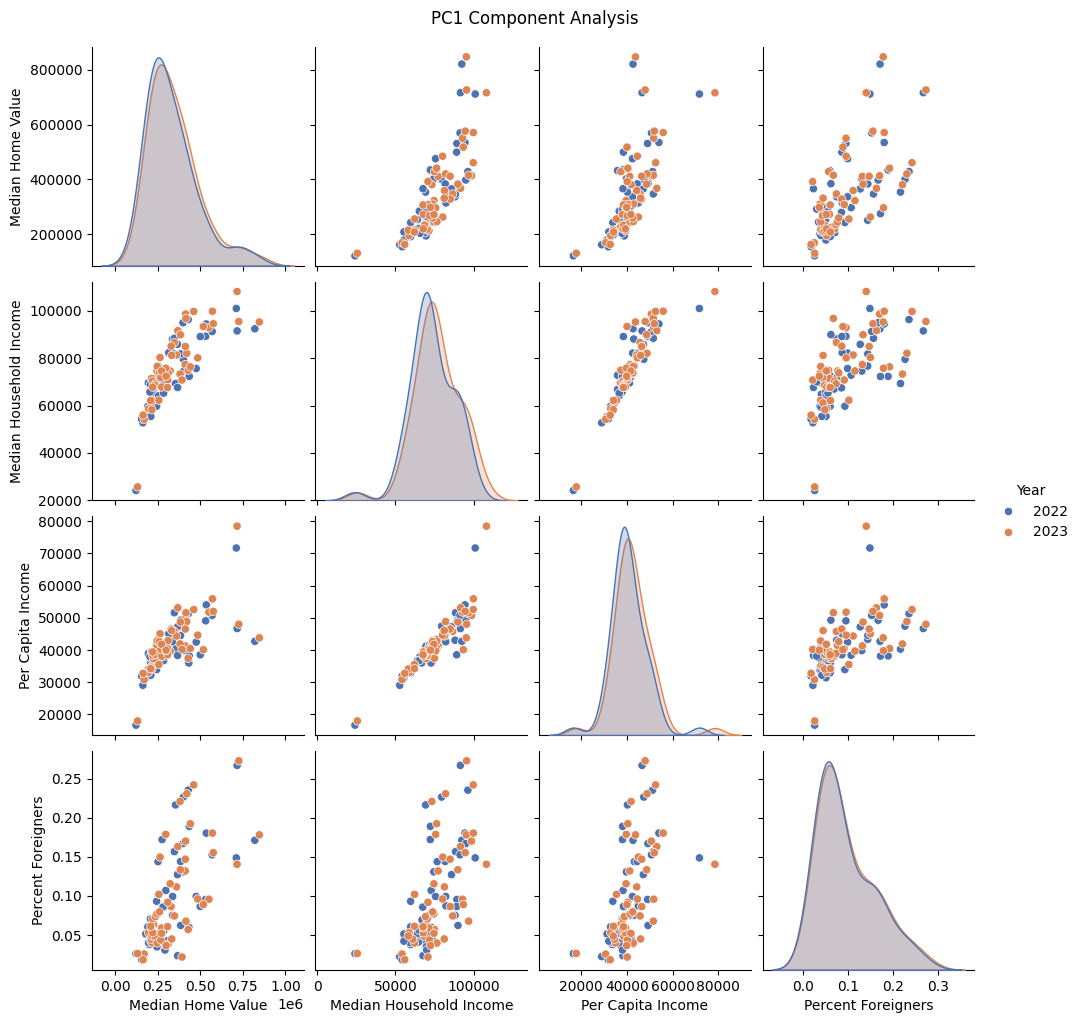

In [10]:
# Analyse PC1 on the original df with both 2022 and 2023 data

# Explained Variance by each component
explainedVariance_byComponent = pca.explained_variance_ratio_

explainedVariance_PC1 = explainedVariance_byComponent[0]
print(f"PC1 explains {explainedVariance_PC1*100:.2f}% of the total variance")

# Create a SPLOM for Main components of PC1 identified earlier
main_cols_pc1 = ['Median Home Value','Median Household Income', 'Per Capita Income', 'Percent Foreigners']
img_name_pc1 = 'acs_PC1_SPLOMs'
cols = main_cols_pc1
img_name = img_name_pc1

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC1 Component Analysis', y=1.02) 
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC1**
- Main components of PC1 are linearly correlated. PC1 here aligns with the directions where the most correlated features exist—because these correlations reflect the shared structure in the data.
- The first principal component (PC1) captures the largest proportion of variance. If features are correlated, they will share a significant portion of this variance, and PC1 will represent this shared variance.

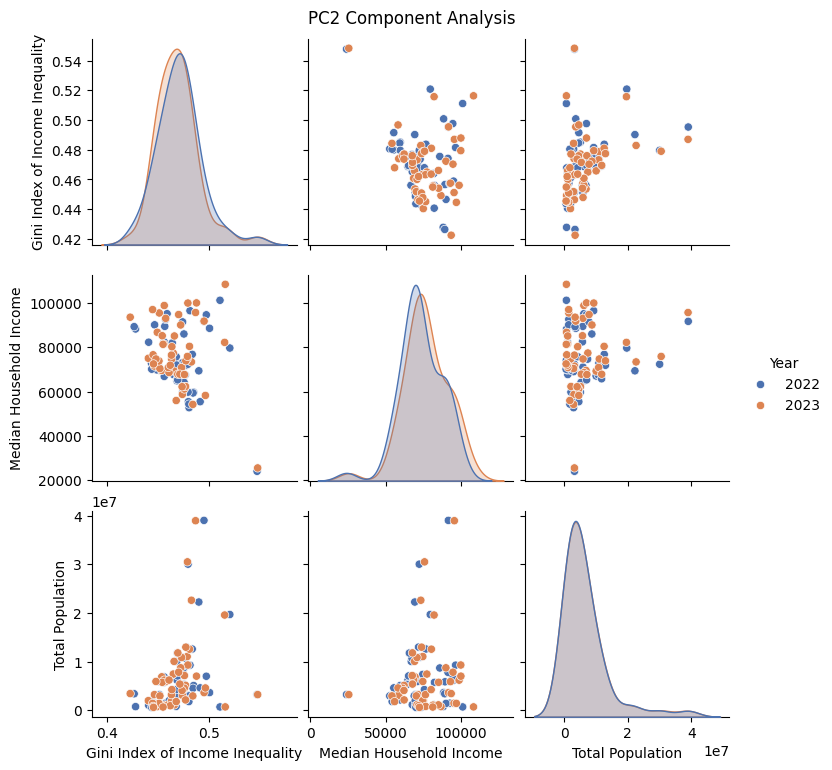

In [11]:
# Analyse PC2
# Main features for PC2 -> No strong correlations observed; Expected because it's capturing the remnants from PC1 (side trends)
main_cols_pc2 = ['Gini Index of Income Inequality','Median Household Income', 'Total Population']
img_name_pc2 = 'acs_PC2_SPLOMs'
cols = main_cols_pc2
img_name = img_name_pc2

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC2 Component Analysis', y=1.02) 
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC2**
- The variables seem to be less correlated compared to PC1, showing no clear linear relationship.
- PC2 highlights important variations that aren’t tied to the most correlated features but still carry significant demographic or economic information

### MDS

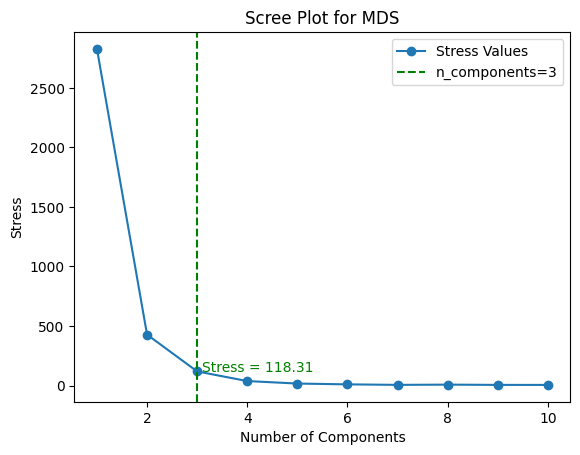

In [12]:
X = acs_2023_df_scaled[numeric_cols]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run MDS for different numbers of components
stress_values = []
n_components_range = np.arange(1, 11)  # Try MDS with 1 to 10 dimensions

for n_components in n_components_range:
    mds = MDS(n_components=n_components, random_state=42)
    mds.fit(X_scaled)
    stress_values.append(mds.stress_)

# Find optimal number of components (elbow point)
optimal_n_components = 3  # Based on visual inspection

# Plot scree-like plot for MDS stress
plt.plot(n_components_range, stress_values, marker='o', label='Stress Values')

# Add vertical line at the chosen n_components
plt.axvline(x=optimal_n_components, color='g', linestyle='--', label=f'n_components={optimal_n_components}')

# Annotate with stress at the chosen n_components
plt.text(optimal_n_components + 0.1, stress_values[optimal_n_components - 1], 
         f'Stress = {stress_values[optimal_n_components - 1]:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Stress')
plt.title('Scree Plot for MDS')

# Save and show plot
img_name = 'MDS_Stress_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()


In [13]:
# Perform MDS with n_components = 3
n=3
mds = MDS(n_components=n, random_state=42)

# MDS results 
mds_2023_result = mds.fit_transform(acs_2023_df_scaled[numeric_cols])
mds_2023_df = pd.DataFrame(mds_2023_result, columns=[f'MDS_D{i+1}' for i in range(n)])
# Concatenate the original data with mds components
acs_with_mds_2023_df = pd.concat([acs_2023_df.reset_index(drop=True), mds_2023_df], axis=1)
# acs_with_mds_2023_df.to_csv('assets/acs_with_mds_2023.csv') 
acs_with_mds_2023_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Name,State Code (USPS),MDS_D1,MDS_D2,MDS_D3
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,Alabama,AL,0.952345,0.212468,-1.707963
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,Alaska,AK,-1.878192,-0.771679,-0.416824
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,Arizona,AZ,-0.238285,-0.201785,0.376492
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,Arkansas,AR,0.843026,-0.101269,-2.049780
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,California,CA,0.999952,-3.416455,5.279470


## Clustering

### KMeans

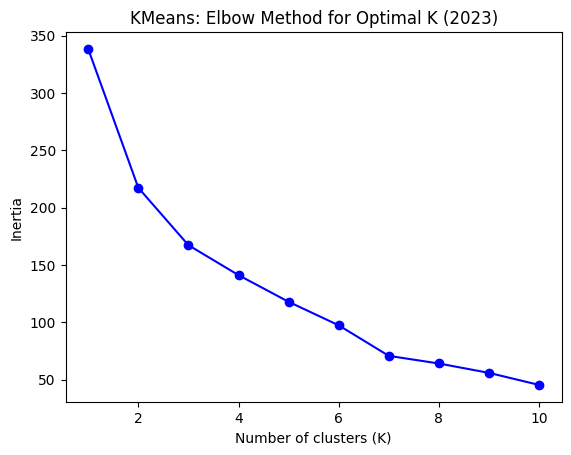

In [14]:
# Perform KMeans Clustering on PCA results (PCA + KMeans)
pca_cols = [col for col in acs_with_pca_2023_df if 'PC' in col]

# Find most appropriate number of clusters
# Define range of K values
K = range(1, 11)

# Store inertia values for each K
# Inertia = within-cluster sum of squares (WCSS) 
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(acs_with_pca_2023_df[pca_cols])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
img_name = 'KMeans_with_PCA_Elbow'
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans: Elbow Method for Optimal K (2023)')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()
# K=3,4 both look ok. Let's compare Silhoutte Scores

In [16]:
# Compare Silhouette Score for K=3 and K=4

# For K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(acs_with_pca_2023_df[pca_cols])
labels_3 = kmeans_3.labels_

# Compute silhouette score for K=3
silhouette_score_k3 = silhouette_score(acs_with_pca_2023_df[pca_cols], labels_3)
print(f'Silhouette Score for K=3: {silhouette_score_k3}')

# For K=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(acs_with_pca_2023_df[pca_cols])
labels_4 = kmeans_4.labels_

# Compute silhouette score for K=4
silhouette_score_k4 = silhouette_score(acs_with_pca_2023_df[pca_cols], labels_4)
print(f'Silhouette Score for K=4: {silhouette_score_k4}')

Silhouette Score for K=3: 0.29835630706652627
Silhouette Score for K=4: 0.2586042606267848


PCA+KMeans(k=3)

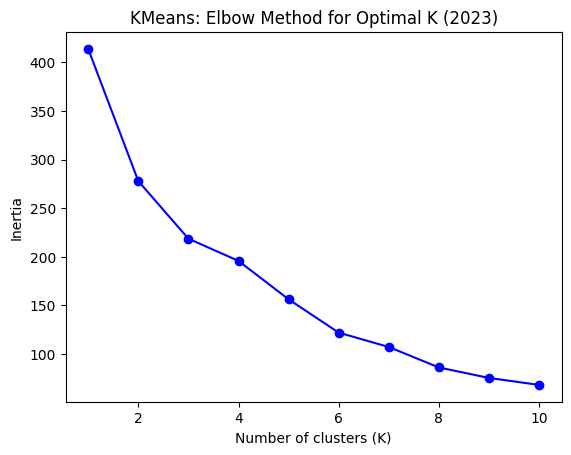

In [15]:
# Perform KMeans Clustering on MDS results (MDS + KMeans)
mds_cols = [col for col in acs_with_mds_2023_df if 'MDS' in col]

# Find most appropriate number of clusters
# Define range of K values
K = range(1, 11)

# Store inertia values for each K
# Inertia = within-cluster sum of squares (WCSS) 
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(acs_with_mds_2023_df[mds_cols])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
img_name = 'KMeans_with_MDS_Elbow'
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans: Elbow Method for Optimal K (2023)')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()
# K=3.

Based on Elbow method: MDS+KMeans(k=3), same as PCA

In [ ]:
k = 3

kmeans_forPCA = KMeans(n_clusters=k, random_state=42)
acs_with_pca_and_kmeans_2023 = acs_with_pca_2023_df.copy()
acs_with_pca_and_kmeans_2023['KMeans_Cluster'] = kmeans_forPCA.fit_predict(acs_with_pca_and_kmeans_2023[pca_cols])
acs_with_pca_and_kmeans_2023.head()

kmeans_forMDS = KMeans(n_clusters=k, random_state=42)
acs_with_mds_and_kmeans_2023 = acs_with_mds_2023_df.copy()
acs_with_mds_and_kmeans_2023['KMeans_Cluster'] = kmeans_forMDS.fit_predict(acs_with_mds_and_kmeans_2023[mds_cols])
acs_with_mds_and_kmeans_2023.head()